<a href="https://colab.research.google.com/github/utkarsh0702/Projects/blob/master/Door_Open_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import os
from tensorflow import keras
import zipfile
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
local_zip= '/content/drive/My Drive/datasets/Images.zip'
zip_ref= zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [0]:
train_door_c_dir= os.path.join('/content/Images/Train/Door Close')
train_door_o_dir= os.path.join('/content/Images/Train/Door Open')
test_door_c_dir= os.path.join('/content/Images/Test/Door Close')
test_door_o_dir= os.path.join('/content/Images/Test/Door Open')

In [0]:
print('Total train door close images: ',len(os.listdir(train_door_c_dir)))
print('Total train door open images: ',len(os.listdir(train_door_o_dir)))
print('Total test door close images: ',len(os.listdir(test_door_c_dir)))
print('Total test door open images: ',len(os.listdir(test_door_o_dir)))

Total train door close images:  244
Total train door open images:  190
Total test door close images:  60
Total test door open images:  47


In [0]:
! pip install -q tensorflow-model-optimization

     |████████████████████████████████| 174kB 6.3MB/s 
     |████████████████████████████████| 296kB 34.7MB/s 


In [0]:
from tensorflow_model_optimization.sparsity import keras as sparsity

In [0]:
epochs = 10
end_step = np.ceil(1.0 * 28 / 5).astype(np.int32) * epochs
print('End step: ' + str(end_step))

End step: 60


In [0]:
pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=21,
                                                   end_step=end_step,
                                                   frequency=100)
}

In [0]:
tf.keras.backend.clear_session()

model= keras.Sequential([
                         sparsity.prune_low_magnitude(keras.layers.Conv2D(16,(3,3), activation='relu', padding='same', input_shape=(300,300,3)),**pruning_params),
                         keras.layers.MaxPooling2D(2,2),
                         keras.layers.BatchNormalization(axis= 3),
                         sparsity.prune_low_magnitude(keras.layers.Conv2D(32,(3,3), activation='relu'),**pruning_params),
                         keras.layers.MaxPooling2D(2,2),
                         keras.layers.Dropout(0.4),
                         sparsity.prune_low_magnitude(keras.layers.Conv2D(32,(3,3), activation='relu'),**pruning_params),
                         keras.layers.MaxPooling2D(2,2),
                         keras.layers.BatchNormalization(axis= 3),
                         sparsity.prune_low_magnitude(keras.layers.Conv2D(64,(3,3), activation='relu'),**pruning_params),
                         keras.layers.MaxPooling2D(2,2),
                         keras.layers.Dropout(0.4),
                         sparsity.prune_low_magnitude(keras.layers.Conv2D(64,(3,3), activation='relu'),**pruning_params),
                         keras.layers.MaxPooling2D(2,2),
                         keras.layers.BatchNormalization(axis= 3),
                         sparsity.prune_low_magnitude(keras.layers.DepthwiseConv2D((3, 3), (1, 1), activation = "relu"),**pruning_params),
                         keras.layers.MaxPooling2D(2,2),
                         keras.layers.Dropout(0.4),
                         keras.layers.GlobalAveragePooling2D(),
                         sparsity.prune_low_magnitude(keras.layers.Dense(512, activation='relu', activity_regularizer=keras.regularizers.l2(0.01)),**pruning_params),
                         keras.layers.Dropout(0.2),
                         sparsity.prune_low_magnitude(keras.layers.Dense(1, activation='sigmoid'),**pruning_params)
                         ])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 300, 300, 16)      882       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 16)      64        
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 148, 148, 32)      9250      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
prune_low_magnitude_conv2d_2 (None, 72, 72, 32)        1

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen= ImageDataGenerator(
    rescale= 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_gen= train_datagen.flow_from_directory( '/content/Images/Train',
                                            target_size=(300,300),
                                            batch_size=9,
                                            class_mode='binary')

test_datagen= ImageDataGenerator(
    rescale= 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_gen= test_datagen.flow_from_directory( '/content/Images/Test',
                                            target_size=(300,300),
                                            batch_size=3,
                                            class_mode='binary')

Found 434 images belonging to 2 classes.
Found 107 images belonging to 2 classes.


In [0]:
class myCall(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>0.85):
      print('\nThe Training is Cancelled.....')
      self.model.stop_training= True

callbacks = [
    sparsity.UpdatePruningStep(),
    myCall()
] 

In [0]:
history= model.fit_generator( train_gen,
                   steps_per_epoch=50,
                   epochs=50,
                   validation_data= test_gen,
                   validation_steps= 50,
                   verbose=2,
                  callbacks=[callbacks] )

Epoch 1/50
50/50 - 30s - loss: 0.6643 - acc: 0.6388 - val_loss: 0.6934 - val_acc: 0.5503
Epoch 2/50
50/50 - 30s - loss: 0.5768 - acc: 0.6907 - val_loss: 0.6800 - val_acc: 0.5906
Epoch 3/50
50/50 - 30s - loss: 0.4874 - acc: 0.7833 - val_loss: 0.7259 - val_acc: 0.5608
Epoch 4/50
50/50 - 30s - loss: 0.4525 - acc: 0.7788 - val_loss: 0.7051 - val_acc: 0.5503
Epoch 5/50
50/50 - 30s - loss: 0.4096 - acc: 0.8194 - val_loss: 0.7294 - val_acc: 0.5676
Epoch 6/50
50/50 - 30s - loss: 0.3669 - acc: 0.8691 - val_loss: 0.7212 - val_acc: 0.5638
Epoch 7/50
50/50 - 30s - loss: 0.3567 - acc: 0.8352 - val_loss: 0.8166 - val_acc: 0.5705
Epoch 8/50
50/50 - 30s - loss: 0.3783 - acc: 0.8307 - val_loss: 0.8592 - val_acc: 0.5676
Epoch 9/50
50/50 - 30s - loss: 0.3172 - acc: 0.8758 - val_loss: 0.8746 - val_acc: 0.5369
Epoch 10/50
50/50 - 30s - loss: 0.3027 - acc: 0.8736 - val_loss: 0.9682 - val_acc: 0.5676
Epoch 11/50
50/50 - 30s - loss: 0.3164 - acc: 0.8736 - val_loss: 1.1376 - val_acc: 0.5772
Epoch 12/50
50/50 -

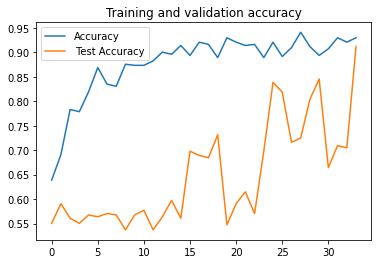

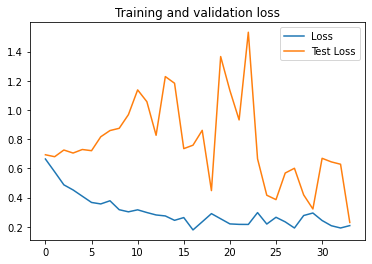

In [0]:
acc= history.history['acc']
val_acc= history.history['val_acc']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs= range(len(acc))
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, label=' Test Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.show()

plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, label='Test Loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.show()

In [0]:
from google.colab import files
from tensorflow.keras.preprocessing import image

In [0]:
model1 = sparsity.strip_pruning(model)

In [0]:
model1.save('Door_Model.h5')

Saving door.png to door (1).png
Saving download.jpg to download (1).jpg
Saving holding-door.jpg to holding-door (1).jpg
Saving images.jpg to images (1).jpg
Saving photo-1535556572967-276cd0ad5cba.jpg to photo-1535556572967-276cd0ad5cba (1).jpg
Saving young-businessman-standing-dark-room-front-closed-door-thinking-his-next-step-entrance-to-unknown-difficult-decision-115176147.jpg to young-businessman-standing-dark-room-front-closed-door-thinking-his-next-step-entrance-to-unknown-difficult-decision-115176147 (1).jpg


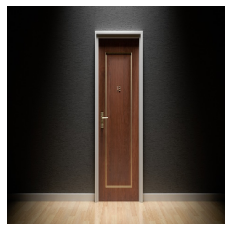

[1.]
Close Door


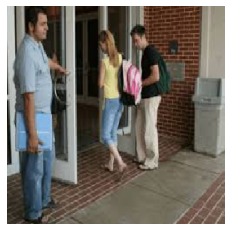

[1.]
Close Door


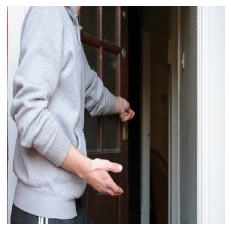

[1.]
Close Door


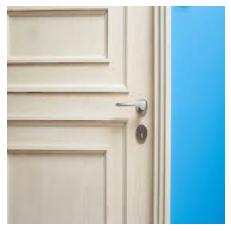

[1.]
Close Door


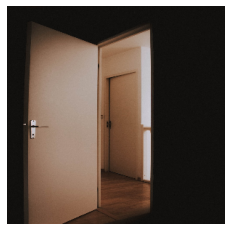

[1.]
Close Door


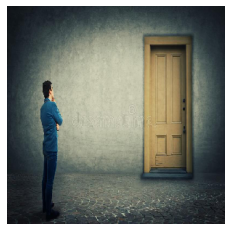

[1.]
Close Door


In [0]:
uploaded= files.upload()

for fn in uploaded.keys():
  # predict image
  path='/content/' + fn
  img= image.load_img(path, target_size=(300,300))
  plt.axis('off')
  plt.imshow(img)
  plt.show()
  x= image.img_to_array(img)
  x= np.expand_dims(x, axis=0)
  
  images= np.vstack([x])
  classes= model1.predict(images, batch_size=10)
  print(classes[0])
  if(classes[0]>0.9):
    print('Close Door')
    
  else:
    print('Open Door')
  